# Data Analysis of Telecommunication Company Dataset using R

##### Dataset is randomly collected from an Iranian telecom company's database. It contains attributes of 3150 customers aggregated over 9 months, along with information of whether a customer churned or not, collected at the end of 12 month period. Entire analysis includes minor data preparation, EDA with some visualizations and statistical tests, as well as logistic regression model for prediction of customer churning.

### Data preperation
Renaming variables, setting categorical ones to factors and adding additional columns for more insights.
Then viewing dataset and it's structure.

In [413]:
options(warn=-1)
suppressMessages(library(tidyverse))
suppressMessages(library(corrplot))
library(caTools)
library(broom)
library(agricolae)

In [391]:
data <- read.csv("Customer Churn.csv")

col_nm <- colnames(data)
data <- as_tibble(data[ ,-c(12,14,15)]) %>% 
    rename('call_fails'=col_nm[1], 'complaints'=col_nm[2], 'sub_len_mnths'=col_nm[3],
           'charge_amt'=col_nm[4], 'total_calls_sec'=col_nm[5], 'calls_nr'=col_nm[6],
           'sms_nr'=col_nm[7], 'dist_calls_nr'=col_nm[8], 'age'=col_nm[9],
           'tariff'=col_nm[10], 'status'=col_nm[11], 'cust_val'=col_nm[13], 'churn'=col_nm[16]) %>%
    mutate(complaints=factor(complaints, levels=c(0,1), labels=c('None','Present')),
           churn=factor(churn, levels=c(0,1), labels=c('No','Yes')),
           charge_amt=factor(charge_amt, levels=0:9, ordered=T),
           total_calls_min=total_calls_sec %/% 60,
           age=factor(age, levels=c(1:5), labels=c('<25','25-29','30-44','45-54','>55')),
           tariff=factor(tariff, levels=c(1,2), labels=c('PAYG','Contractual')),
           status=factor(status, levels=c(1,2), labels=c('Active','Non-Active')),
           sub_len_yrs=sub_len_mnths %/% 12,
           avg_call_dur_sec=ifelse(calls_nr>0, total_calls_sec/calls_nr, 0)) %>%
    relocate(churn,tariff,status,complaints,cust_val,charge_amt,age,sub_len_yrs,sub_len_mnths,
             sms_nr,calls_nr,call_fails,dist_calls_nr,avg_call_dur_sec,total_calls_min,total_calls_sec)

head(data, n=5)
glimpse(data)

churn,tariff,status,complaints,cust_val,charge_amt,age,sub_len_yrs,sub_len_mnths,sms_nr,calls_nr,call_fails,dist_calls_nr,avg_call_dur_sec,total_calls_min,total_calls_sec
<fct>,<fct>,<fct>,<fct>,<dbl>,<ord>,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
No,PAYG,Active,None,197.640,0,30-44,3,38,5,71,8,17,61.54930,72,4370
No,PAYG,Non-Active,None,46.035,0,25-29,3,39,7,5,0,4,63.60000,5,318
No,PAYG,Active,None,1536.520,0,30-44,3,37,359,60,10,24,40.88333,40,2453
No,PAYG,Active,None,240.020,0,<25,3,38,1,66,10,35,63.60606,69,4198
No,PAYG,Active,None,145.805,0,<25,3,38,2,58,3,33,41.25862,39,2393


Rows: 3,150
Columns: 16
$ churn            <fct> No, No, No, No, No, No, No, No, No, No, No, No, No, N…
$ tariff           <fct> PAYG, PAYG, PAYG, PAYG, PAYG, PAYG, PAYG, PAYG, PAYG,…
$ status           <fct> Active, Non-Active, Active, Active, Active, Active, A…
$ complaints       <fct> None, None, None, None, None, None, None, None, None,…
$ cust_val         <dbl> 197.640, 46.035, 1536.520, 240.020, 145.805, 282.280,…
$ charge_amt       <ord> 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 3, 1, 0, 1, 0, 0,…
$ age              <fct> 30-44, 25-29, 30-44, <25, <25, 30-44, 30-44, 30-44, 3…
$ sub_len_yrs      <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ sub_len_mnths    <int> 38, 39, 37, 38, 38, 38, 38, 37, 38, 38, 38, 38, 38, 3…
$ sms_nr           <int> 5, 7, 359, 1, 2, 32, 285, 144, 0, 2, 7, 8, 54, 483, 1…
$ calls_nr         <int> 71, 5, 60, 66, 58, 82, 39, 121, 169, 83, 95, 54, 225,…
$ call_fails       <int> 8, 0, 10, 10, 3, 11, 4, 13, 7, 7, 6, 9, 25, 4, 9, 3, …
$ dist_calls_nr 

### Exploratory Data Analysis
After checking correlations between all numerical variables, dependency between pre-calculated 'Customer Value' and SMS frequency was strongest and most reasonable one to inspect. 
While graphing simple linear model and preliminarily checking for larger groupings, age turned out to be most interesting one to inspect further. After carrying out ANOVA, people with ages from 25 to 44 were confirmed as the most valuable customers.

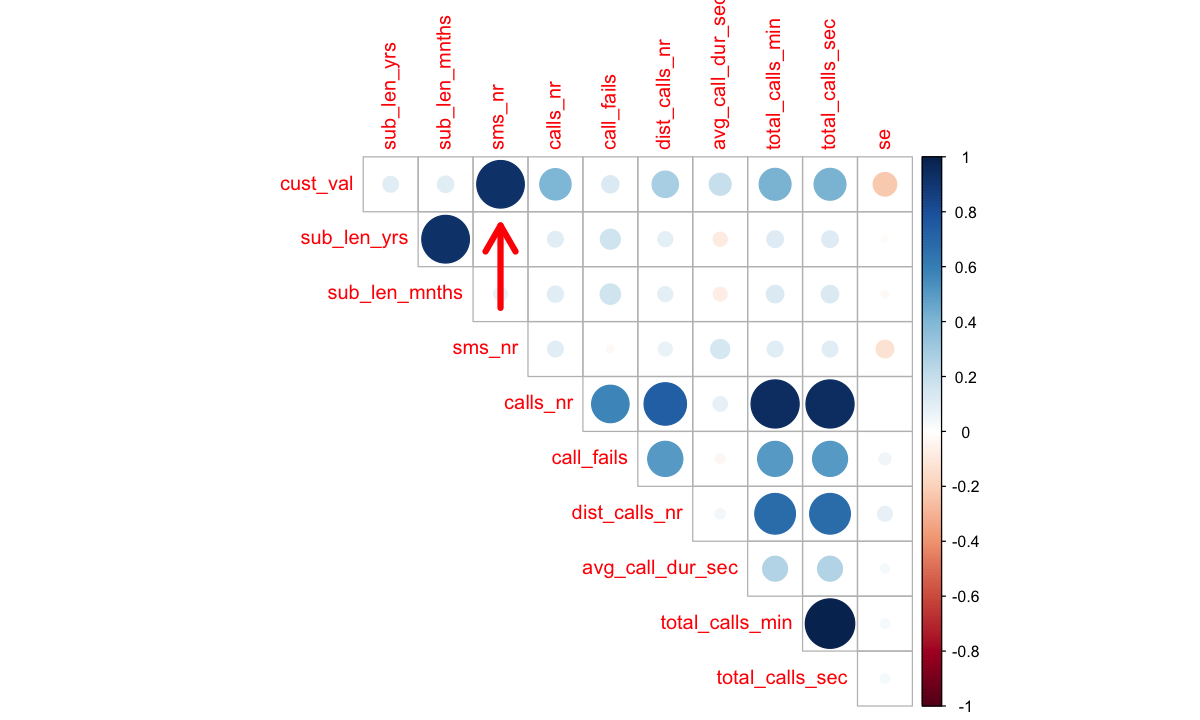

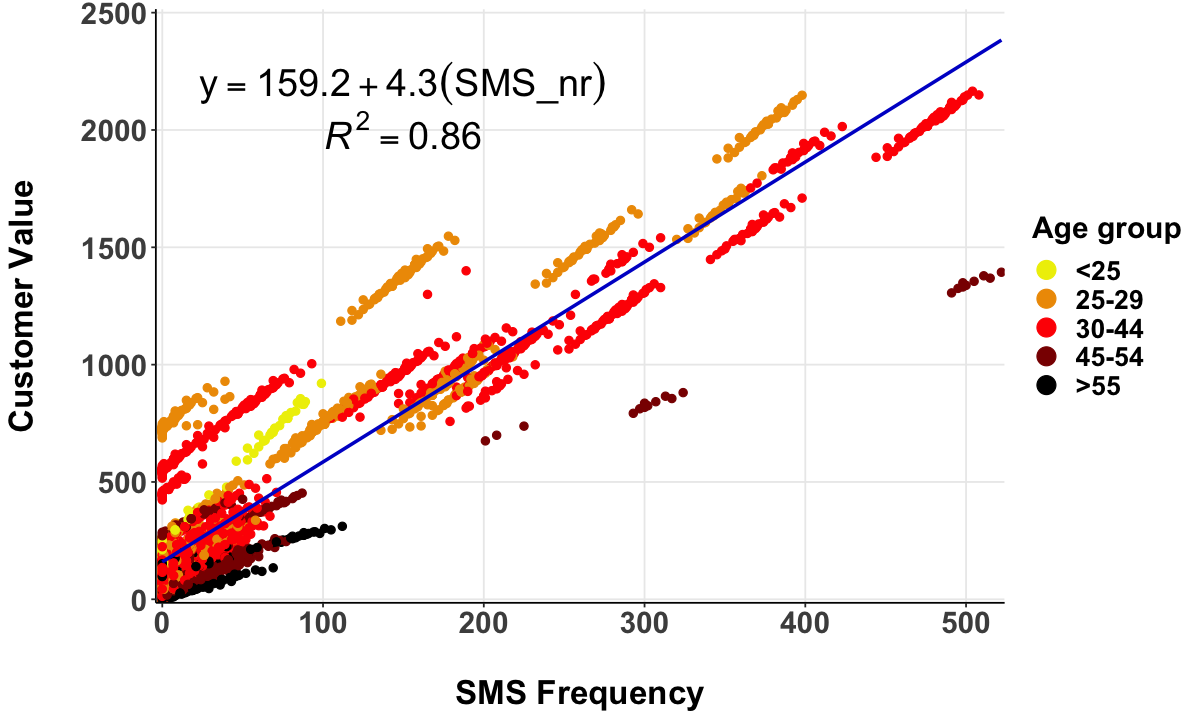

Customers who sent more than 100 SMS constitute 24% of all customers and their average `Customer Value` is on
average 6 times greater then other customers. Therefore, it is worth targeting this specific customer group.

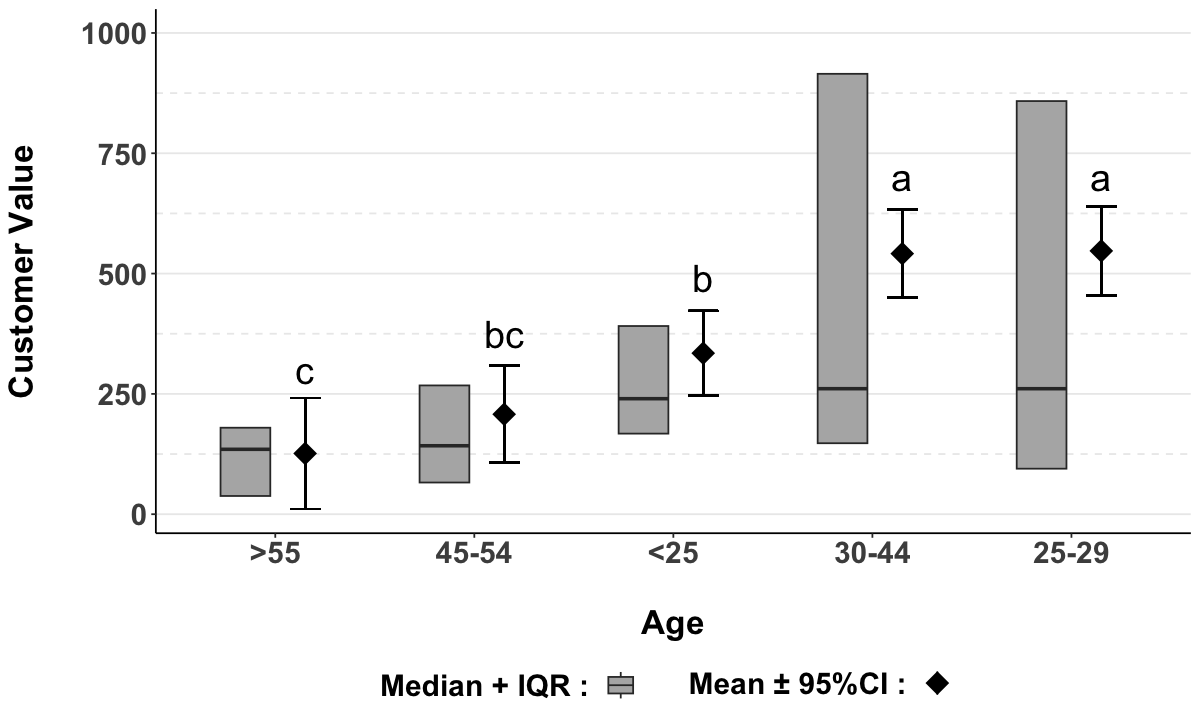

In [461]:
num_vars = c()
for (var in colnames(data)) {
  if (is.numeric(data[[var]])) {
    num_vars <- c(num_vars, var)
  }
}

options(repr.plot.width=10, repr.plot.height=6)
cor(data[num_vars]) %>% corrplot(type='upper', diag=F)
arrows(4,8.75,4,10.25, lwd=5, col='red')

# : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : #

options(repr.plot.width=10, repr.plot.height=6)
ggplot(data, aes(sms_nr, cust_val)) +
    geom_point(aes(col=age), size=2) +
    geom_smooth(method='lm', formula=y~x, col='blue3', se=F) +
    labs(x='\nSMS Frequency', y='Customer Value\n', col='Age group') +
    theme_classic() +
    coord_cartesian(xlim=c(20,500), ylim=c(100,2400)) +
    annotate(geom='text', x=150, y=2000, label='italic(R)^2==0.86', parse=T, size=8) +
    annotate(geom='text', x=150, y=2200, label='y==159.2+4.3*(SMS_nr)', parse=T, size=8) +
    theme(axis.title.x = element_text(face='bold', size=20),
        axis.title.y = element_text(face='bold', size=20),
        axis.text.x = element_text(face='bold', size=18),
        axis.text.y = element_text(face='bold', size=18),
        panel.grid.major.x = element_line(linewidth=0.5),
        panel.grid.major.y = element_line(linewidth=0.5),
        legend.title = element_text(size=18, face='bold'),
        legend.text = element_text(size=16, face='bold')) +
    scale_color_manual(values=c('yellow2','orange2','red','red4','black')) +
    guides(color = guide_legend(override.aes = list(size = 5)))

# : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : #

mod <- lm(data=data, formula=cust_val~age)
# HSD.test(mod, 'age', console=T)   ...   for post-hoc comparisons and compact letter display

se <- sqrt(diag(vcov(mod)))
data$se <- se[[5]]
data$se[data$age=='45-54'] <- se[[4]]
data$se[data$age=='30-44'] <- se[[3]]
data$se[data$age=='25-29'] <- se[[2]]
data$se[data$age=='<25'] <- se[[1]]

options(repr.plot.width=10, repr.plot.height=6)
data %>% group_by(age) %>%
  mutate(ci_low=mean(cust_val)-1.96*se,
         ci_up=mean(cust_val)+1.96*se) %>%
  ggplot(aes(reorder(age, cust_val, mean), cust_val)) +
  geom_boxplot(outlier.shape = NA, coef=0, width=0.25,
               position=position_nudge(x=-0.15),
               aes(fill='')) +
  stat_summary(fun = mean, shape=18, size=1.5,
               position=position_nudge(x=0.15), aes(color='')) +
  geom_errorbar(aes(ymin=ci_low, ymax=ci_up), width=0.15,
                position=position_nudge(x=0.15)) +
  labs(x='\nAge', y='Customer Value\n',
       color='Mean ± 95%CI :', fill = 'Median + IQR :') +
  coord_cartesian(ylim=c(10,1000)) +
  theme_classic() +
  scale_color_manual(values='black') +
  scale_fill_manual(values='grey70') +
  annotate(geom='text', x=1.15, y=300, label='c', size=8) +
  annotate(geom='text', x=2.15, y=375, label='bc', size=8) +
  annotate(geom='text', x=3.15, y=490, label='b', size=8) +
  annotate(geom='text', x=4.15, y=700, label='a', size=8) +
  annotate(geom='text', x=5.15, y=700, label='a', size=8) +
  theme(legend.position = 'bottom',
        axis.title.x = element_text(face='bold', size=20),
        axis.title.y = element_text(face='bold', size=20),
        axis.text.x = element_text(face='bold', size=18),
        axis.text.y = element_text(face='bold', size=18),
        panel.grid.major.y = element_line(linewidth=0.5),
        panel.grid.minor.y = element_line(linewidth=0.5, linetype=2),
        legend.title = element_text(size=18, face='bold')) +
    guides(color = guide_legend(override.aes = list(size = 1.5)),
           fill = guide_legend(override.aes = list(size = 7)))

to_prnt <- data %>% 
    mutate(sms_grp=cut(sms_nr,breaks=c(0,100,600),include.lowest = T)) %>%
    group_by(sms_grp) %>%
    summarise(cv_avg=mean(cust_val), n=n())
cat('Customers who sent more than 100 SMS constitute ',
    round(to_prnt$n[2]/(to_prnt$n[1]+to_prnt$n[2])*100),
    '% of all customers and their average `Customer Value` is on\naverage ',
    round(to_prnt$cv_avg[2]/to_prnt$cv_avg[1]),
    ' times greater then other customers. Therefore, it is worth targeting this specific customer group.', sep='')

### Logistic regression
Splitting data into training set and testing set with 7:3 ratio and equal proportion of outcome categories in each group, then building a logistic regression model with training set using backward elimination method to exclude all statistically insignificant coefficients. Afterward, also excluding statistically significant coefficients with negligibly small effect sizes. Informations about model are displayed along with its interpretation, some calculated metrics and graphical representation of it's accuracy.


Informations about model component's:


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.71770097,1.72473084,-0.4161235,6.773197e-01
tariffContractual,-1.99580225,0.57374167,-3.4785729,5.040913e-04
statusNon-Active,2.90040675,0.18285287,15.8619698,1.161917e-56
complaintsPresent,4.18123641,0.32021384,13.0576379,5.748384e-39
sub_len_yrs,-0.57873545,0.10463014,-5.5312500,3.179568e-08
se,-0.02952138,0.03541825,-0.8335073,4.045587e-01


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1915.894,2203,-537.952,1087.904,1122.092,1075.904,2198,2204




Accuracy of model: 87.9%
Sensitivity of model: 72.2%
Specificity of model: 89.4%

Insights from model's parameters:
 • Customers who are on contractual tariff plan are 7.4 times less likely to churn then customers
   who have chosen "Pay-As-You-Go" tariff plan.
 • Customers who filed any complaints are  65.4 times more likely to churn then those who haven't.
 • Customers who are not active are 18.2 times more likely to churn then those who are active.
 • Each progressive year of subscription length increases the odds of customer churning by 1.8 times.




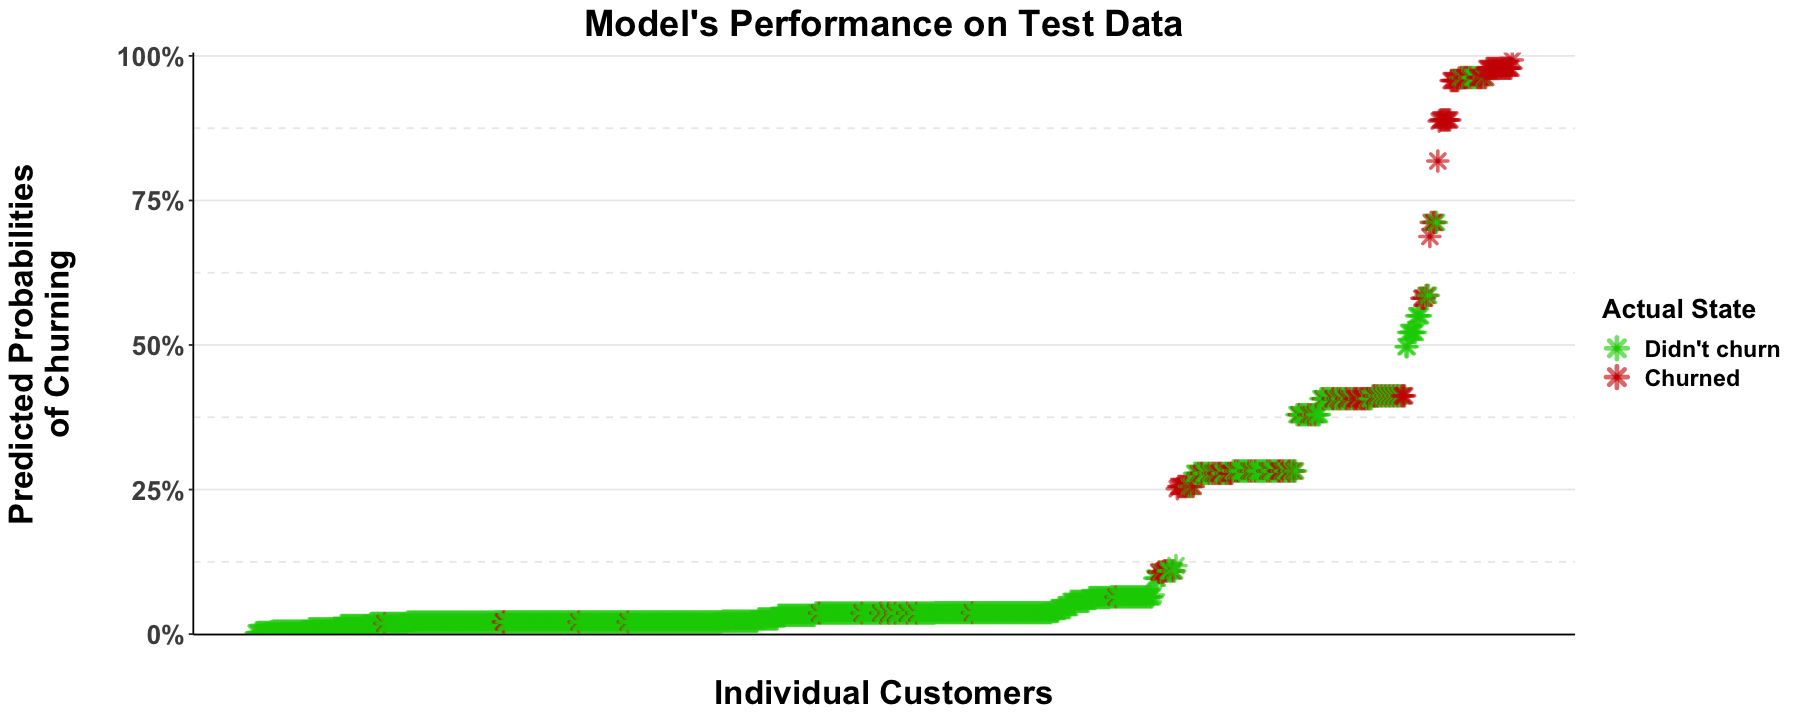

In [427]:
set.seed(1)

split = sample.split(data$churn, SplitRatio=0.7)
train = subset(data, split==T)
test = subset(data, split==F)

model <- glm(data=train, formula=churn~., family='binomial')
model <- update(model,
                .~.-charge_amt-age-total_calls_sec-avg_call_dur_sec-sub_len_mnths-total_calls_min-dist_calls_nr)
model <- update(model,
                .~.-cust_val-sms_nr-calls_nr-call_fails)

test_df <- tibble(actual=test$churn,
                  pred_prob=predict(model, test, type='response'),
                  pred_bin=round(pred_prob)) %>%
    arrange(pred_prob) %>%
    mutate(ID=1:n())

outcomes <- as_tibble(test_df %>% group_by(actual) %>% count(pred_bin)) %>%
    mutate(desc=c('TN','FN','FP','TP'))

accuracy <- sum(outcomes$n[c(1,4)]) / sum(outcomes$n)
sensitivity <- sum(outcomes$n[4]) / sum(outcomes$n[c(2,4)])
specificity <- sum(outcomes$n[1]) / sum(outcomes$n[c(1,3)])

# : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : #

cat('\nInformations about model component\'s:\n')
tidy(model)
glance(model)

cat('\n\nAccuracy of model: ', round(accuracy, 3)*100, '%\n', sep='')
cat('Sensitivity of model: ', round(sensitivity, 3)*100, '%\n', sep='')
cat('Specificity of model: ', round(specificity, 3)*100, '%\n\n', sep='')
cat('Insights from model\'s parameters:\n',
    '• Customers who are on contractual tariff plan are',
    round(1/exp(model$coefficient[2]), 1),
    'times less likely to churn then customers\n   who have chosen "Pay-As-You-Go" tariff plan.\n',
    '• Customers who filed any complaints are ',
    round(exp(model$coefficient[4]), 1),
    'times more likely to churn then those who haven\'t.\n',
    '• Customers who are not active are',
    round(exp(model$coefficient[3]), 1),'times more likely to churn then those who are active.\n',
    '• Each progressive year of subscription length increases the odds of customer churning by',
    round(1/exp(model$coefficient[5]), 1), 'times.\n\n\n')

options(repr.plot.width=15, repr.plot.height=6)
ggplot(test_df,
       aes(ID, pred_prob, color=factor(actual, labels=c('Didn\'t churn','Churned')))) +
    geom_point(alpha=0.6, size=3, shape=8, stroke=1.5) +
    labs(x='\nIndividual Customers',
         y='Predicted Probabilities\nof Churning\n',
         color='Actual State',
         title='Model\'s Performance on Test Data') +
    coord_cartesian(ylim=c(0.045,0.96)) +
    theme_classic() +
    theme(plot.title=element_text(size=22,face='bold',hjust=0.5),
          axis.title.x=element_text(size=20, face='bold'),
          axis.title.y=element_text(size=20, face='bold'),
          axis.ticks.x=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_text(size=16,face='bold'),
          panel.grid.major.y=element_line(linewidth=0.5,linetype=1),
          panel.grid.minor.y=element_line(linewidth=0.5,linetype=2),
          legend.title=element_text(size=16, face='bold'),
          legend.text=element_text(size=14, face='bold'),) +
    scale_y_continuous(labels=scales::percent) +
    scale_color_manual(values=c('green3','red3')) +
    guides(color = guide_legend(override.aes = list(size = 3, stroke=2)))